# Small and Large Scale Kinetic Energy


__author__ : Aurélie Albert & Julien Le Sommer (MEOM)

__context__ : 22-GLO-HR project : Lot 1 - Ocean Modelling

__date__ : June, 11 2018

__purpose__ : Metric for the intensity of resolved fine scale turbulent flows in particular in terms of kinetic energy

__detailed description__ : 
The ratio of small over large scale of kinetic energy is defined as :

$$ R = \frac{KES}{KEL} $$

where KES stands for Small Scale Kinetic Energy, KEL Large Scale Kinetic Energy and are calculated as follows :

$$ KES = \frac{1}{2} . [ (u^{'})^{2} + (v^{'})^{2} ] $$

and

$$ KEL = \frac{1}{2} . [ (\bar{u})^{2} + (\bar{v})^{2} ] $$

where $x^{'}$ stands for small scale and $\bar{x}$ for large scale component of signal x.

__practical steps__ :

  * Input data are NATL60-CJM165 daily outputs of surface velocities
  * step 1. : Filtering of input data is performed with Lanczos2DHighPassFilter.py.
  * step 2. : Kinetic energy is computed with cdftool cdfeke available here : https://github.com/meom-group/CDFTOOLS
  * step 3. : Monthly Maps of the ratio of Small Scale over Large Scale Kinetic Energy averaged in 1°x1° boxes
  
__external libraries needed to run this script__ : 

 * GriddedData : https://github.com/lesommer/codes/blob/master/GriddedData.py
 * oocgcm filtering module : https://github.com/lesommer/oocgcm
 
__licence__ : This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

In [2]:
## path for mdules

import sys
sys.path.insert(0,"/home/albert/lib/python")

## imports

import numpy as np
import xarray as xr
import GriddedData
import time

#- Other modules
import numpy.ma as ma
import WavenumberSpectrum as ws

### palette
import matplotlib.cm as mplcm

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

### quick plot
import matplotlib.pyplot as plt

## local/specific imports
import oocgcm
import oocgcm.filtering
import oocgcm.filtering.linearfilters as tf

## histograms
import seaborn as sns
sns.set(color_codes=True)

from decimal import Decimal
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import colorcet as cc

%matplotlib inline

## 3. : Monthly Maps of the ratio of Small Scale over Large Scale Kinetic Energy averaged in 1°x1° boxes

In [3]:
#The grid files including a special mask to apply on fine scale data

dirin="/media/extra/DATA/NATL60/NATL60-I/"
gridfile=dirin+"NATL60_v4.1_cdf_mesh_hgr.nc"
!ls $gridfile
grid=xr.open_dataset(gridfile)
navlat= np.squeeze(grid['nav_lat'])
navlon= np.squeeze(grid['nav_lon'])
diri='/media/extra/DATA/NATL60/NATL60-I/'
tmask='NATL60-CJM165.1d_mask_surf_filt-n80-f0.0125.nc'
mask_filt=np.squeeze(xr.open_dataset(diri+tmask)['tmask'])


/media/extra/DATA/NATL60/NATL60-I/NATL60_v4.1_cdf_mesh_hgr.nc


In [4]:
#a function to produce a map with boxcar averaging on a 1°x1° grid

def plot_boxcar(fig,var,loncrs,latcrs,lon,lat,hpvarm,month,title,vmin,vmax):
    ''' map of the averaged fine scale variance
    '''
    ax = plt.subplot(111)
    ax.autoscale(tight=True)
    truc=np.array(hpvarm)
    truc[truc==0.]=np.nan
    cont=np.isnan(truc)

    pcolor = ax.pcolormesh(loncrs,latcrs,ma.masked_invalid(var),vmin=vmin,vmax=vmax,cmap=cc.cm.rainbow,alpha=1)
    ax.tick_params(labelsize=25)
    ax.contour(lon,lat,cont,alpha=0.5,linewidth=0.000001,antialiased=True)
    cbar = plt.colorbar(pcolor,orientation='horizontal',pad=0.1)
    cbar.ax.tick_params(labelsize=35)
    ax.set_xlabel('Longitude (in degree)',fontsize=20)
    ax.set_ylabel('Latitude (in degree)',fontsize=20)
    cbar.ax.tick_params(labelsize=25)
    plt.text(0,30,month,size=25)
    cbar.set_label(title,fontsize=25)
    return fig


In [5]:
# a function that ultimately produce the map from any given month

def plot_ratio_monthly(t,var1,var2):
    m=str(t+1).zfill(2)
    if t < 9:
        year='2013'
    else:
        year='2012'
    month = {1 : 'january',
           2 : 'february',
           3 : 'march',
           4 : 'april',
           5 : 'may',
           6 : 'june',
           7 : 'july',
           8 : 'august',
           9 : 'september',
           10 : 'october',
           11 : 'november',
           12 : 'december',
    }
    title = { 'KET' : 'Total',
              'KES' : 'Small Scale',
              'KEL' : 'Large Scale' }
    

    tfiles1='/media/extra/DATA/NATL60/NATL60-CJM165-S/EKE/NATL60-CJM165_y'+year+'m'+m+'.1m_'+str(var1)+'.nc'
    tfiles2='/media/extra/DATA/NATL60/NATL60-CJM165-S/EKE/NATL60-CJM165_y'+year+'m'+m+'.1m_'+str(var2)+'.nc'
    data1 = xr.open_dataset(tfiles1)['vomke']
    data2 = xr.open_dataset(tfiles2)['vomke']
    navlat2=np.array(navlat).squeeze()
    navlon2=np.array(navlon).squeeze()
    mgrd = GriddedData.grid2D(navlat=navlat2, navlon=navlon2)
    crs = GriddedData.grdCoarsener(mgrd,crs_factor=60)

    data1_mask=np.zeros(data1.shape)
    data2_mask=np.zeros(data2.shape)
    for tt in np.arange(data1_mask.shape[0]):
        truc=np.squeeze(data1[0,:,:].values)        
        truc[np.where(mask_filt!=1)]=np.nan
        data1_mask[tt,:,:]=truc[:,:]   
        truc=np.squeeze(data2[0,:,:].values)        
        truc[np.where(mask_filt!=1)]=np.nan
        data2_mask[tt,:,:]=truc[:,:]   

    data1m=np.nanmean(data1_mask,axis=0)
    data1c = crs.return_ravel(np.asarray(data1m))
    data1cm = np.nanmedian(data1c,axis=-3)

    data2m=np.nanmean(data2_mask,axis=0)
    data2c = crs.return_ravel(np.asarray(data2m))
    data2cm = np.nanmedian(data2c,axis=-3)

    latcrs=crs.return_ravel(np.asarray(navlat2))
    loncrs=crs.return_ravel(np.asarray(navlon2))
    latcrsm=np.mean(latcrs,axis=-3)
    loncrsm=np.mean(loncrs,axis=-3)

    fig = plt.figure(figsize=(20, 15))
    truc=plot_boxcar(fig,data1cm/data2cm,loncrsm, latcrsm,navlon,navlat,data1[0],month[t+1],'Ratio of mean '+str(title[var1])+' over '+str(title[var2])+' Kinetic Energy',0,2)
    plt.savefig("NATL60_ratio_"+str(var1)+"_over_"+str(var2)+"_monthly_mean_coarse_m"+m+".png")


/home/albert/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/albert/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:717: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/home/albert/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


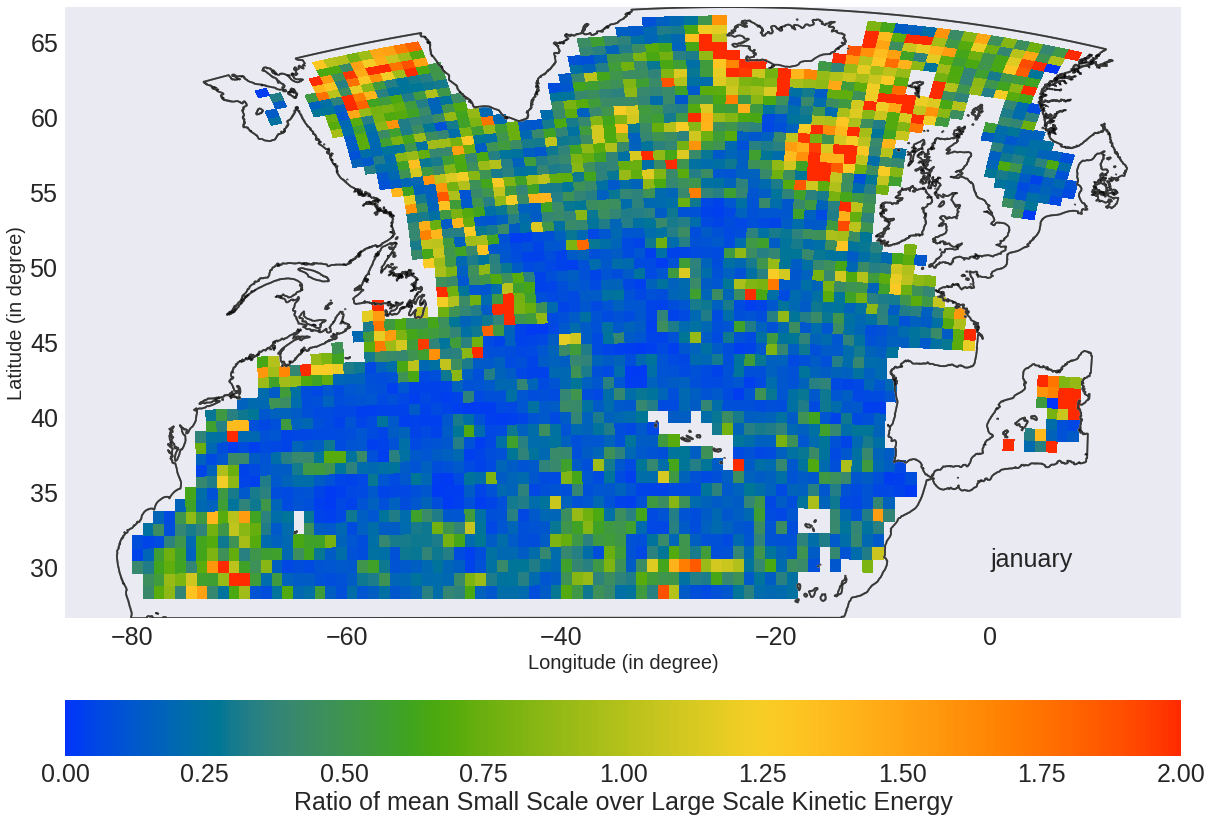

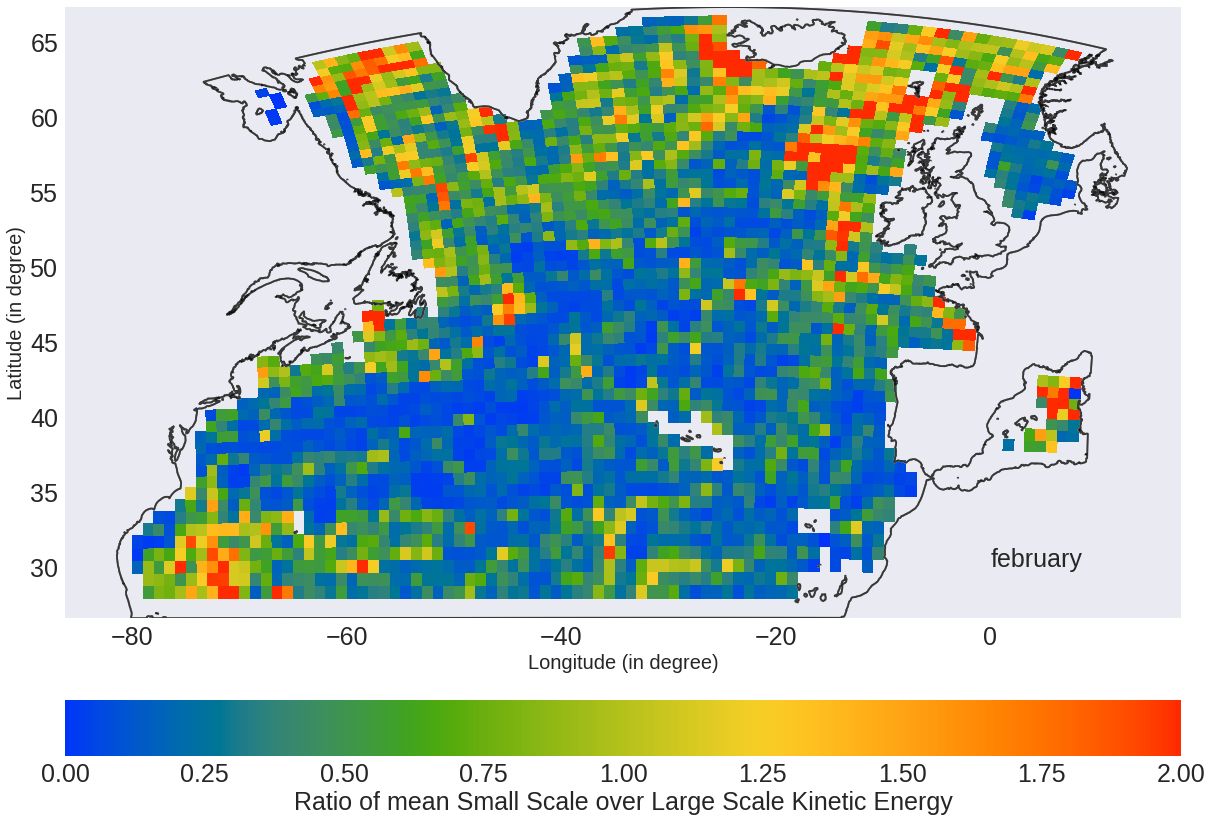

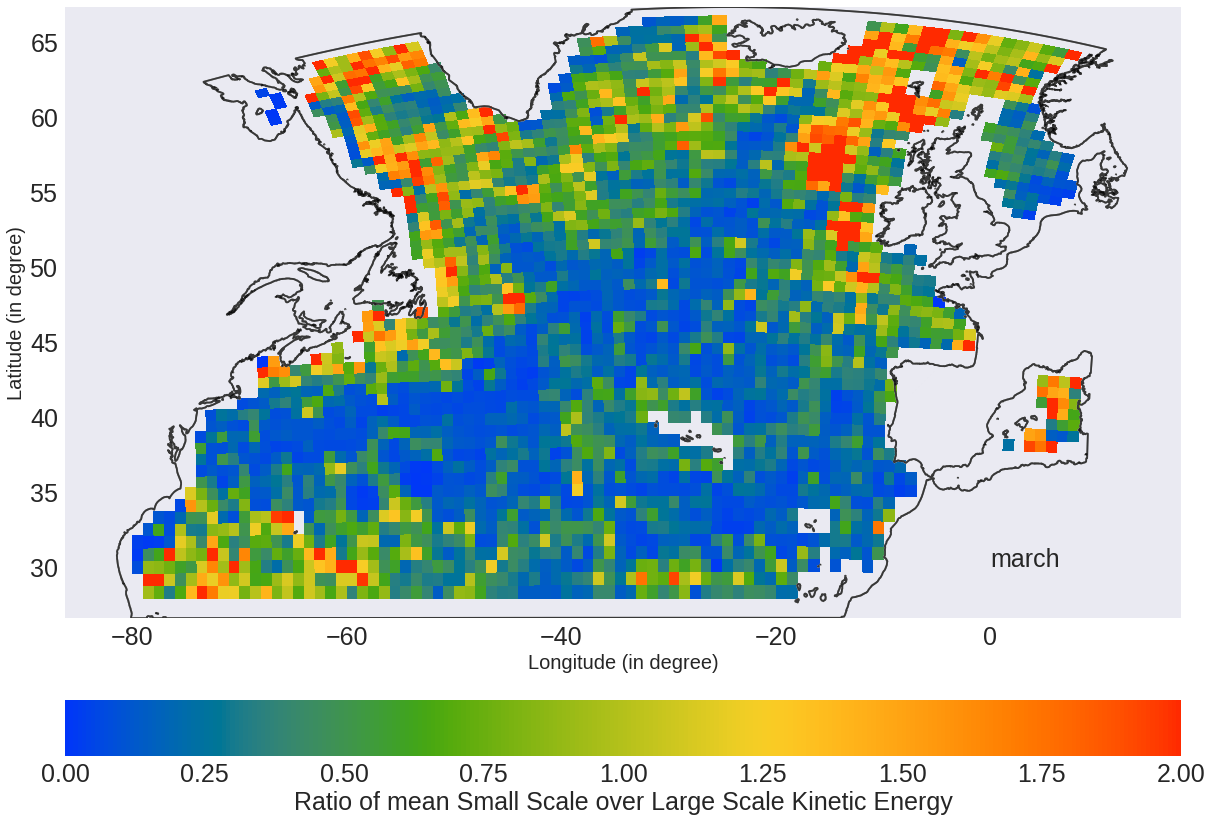

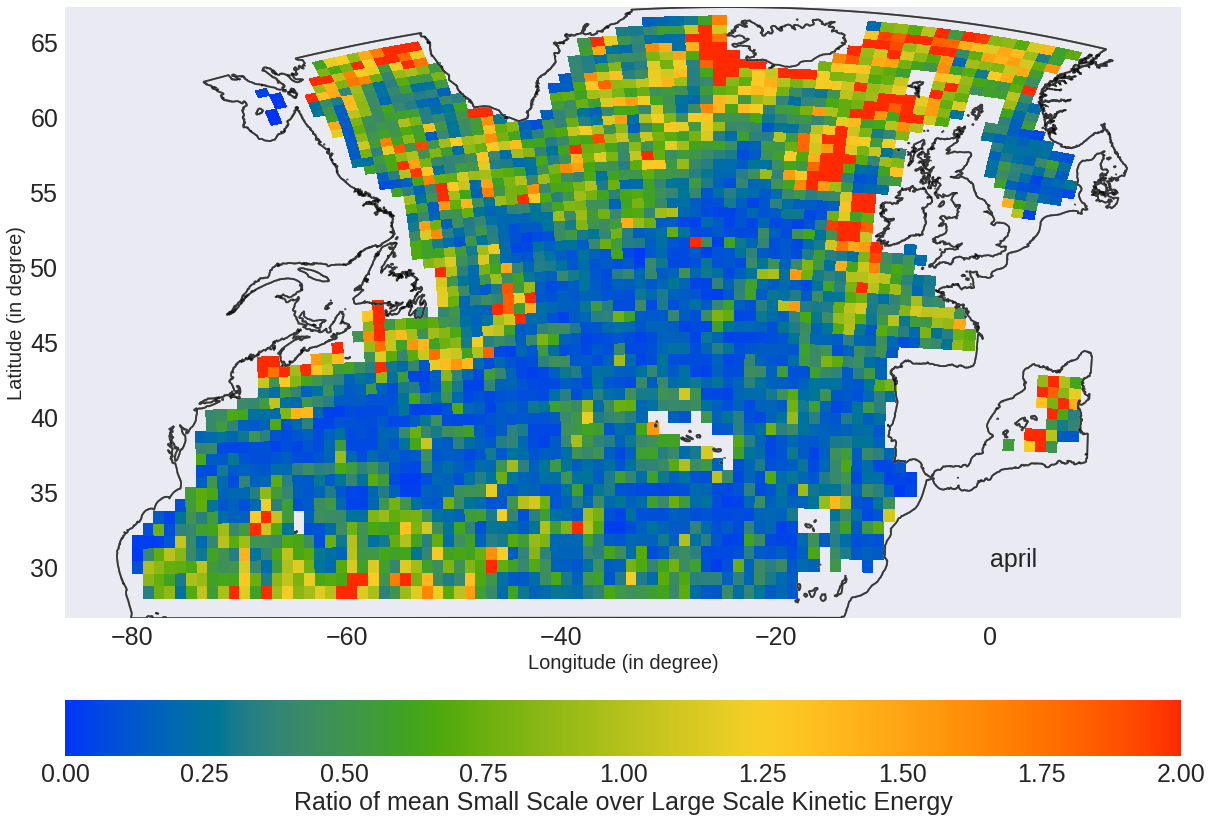

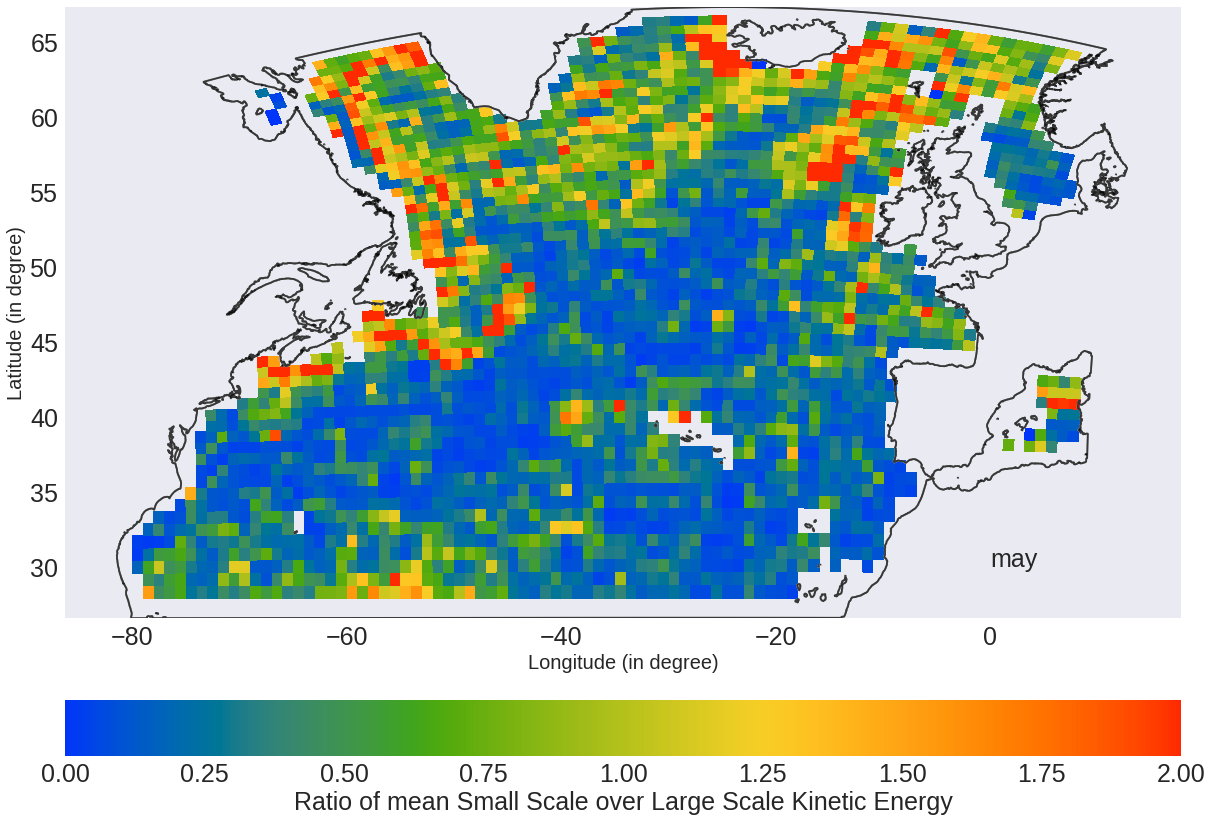

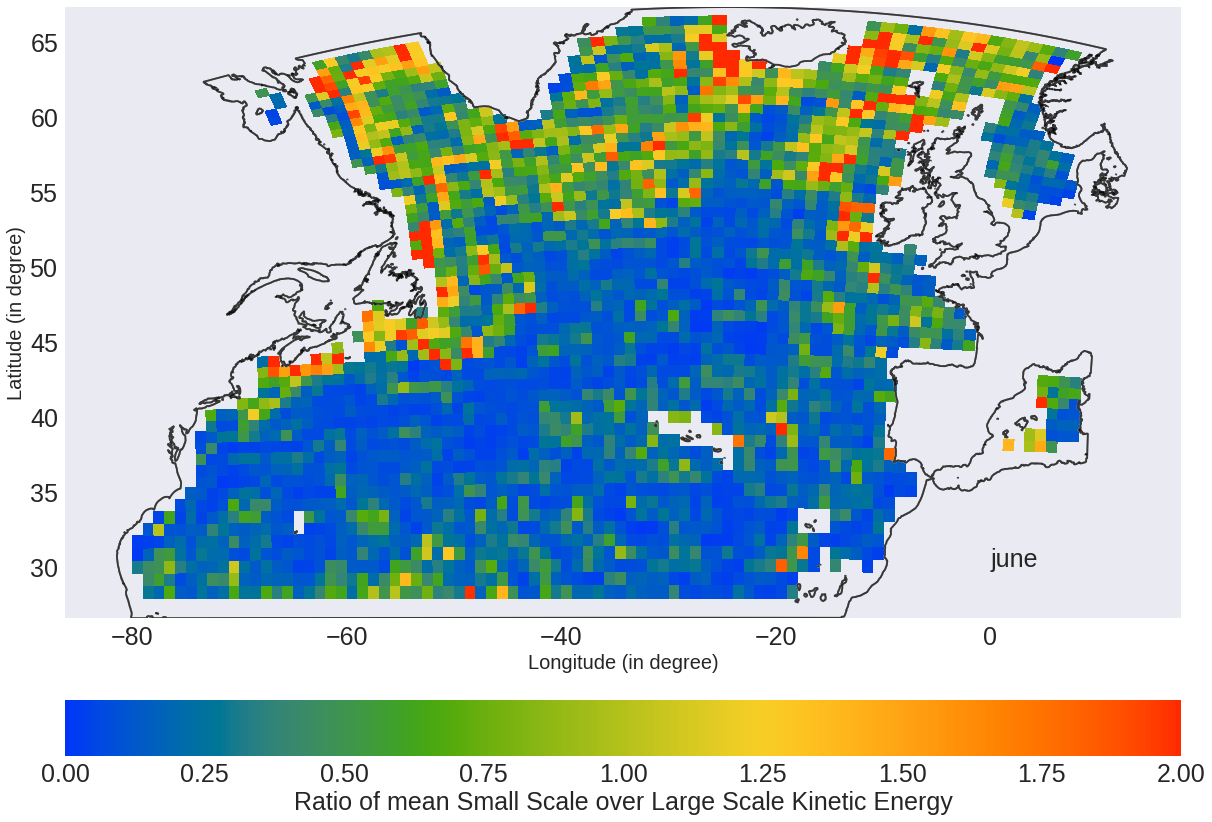

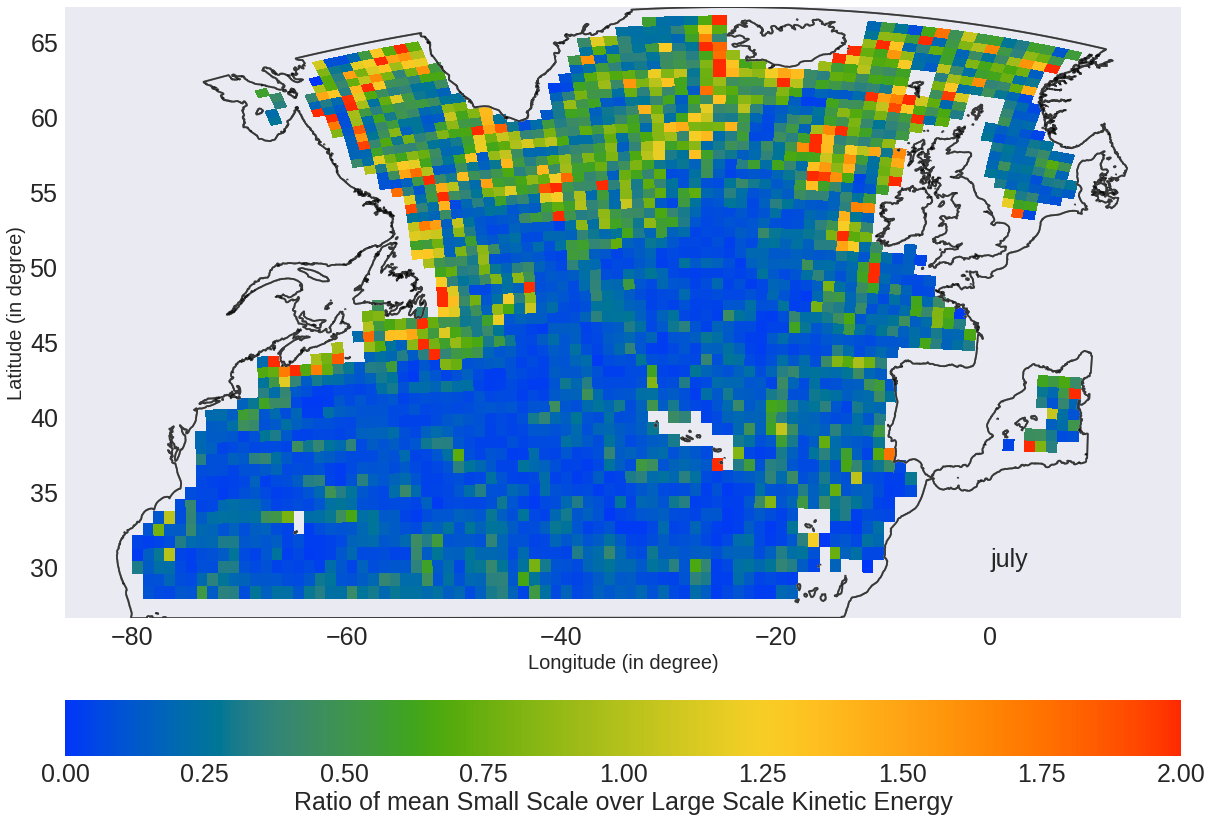

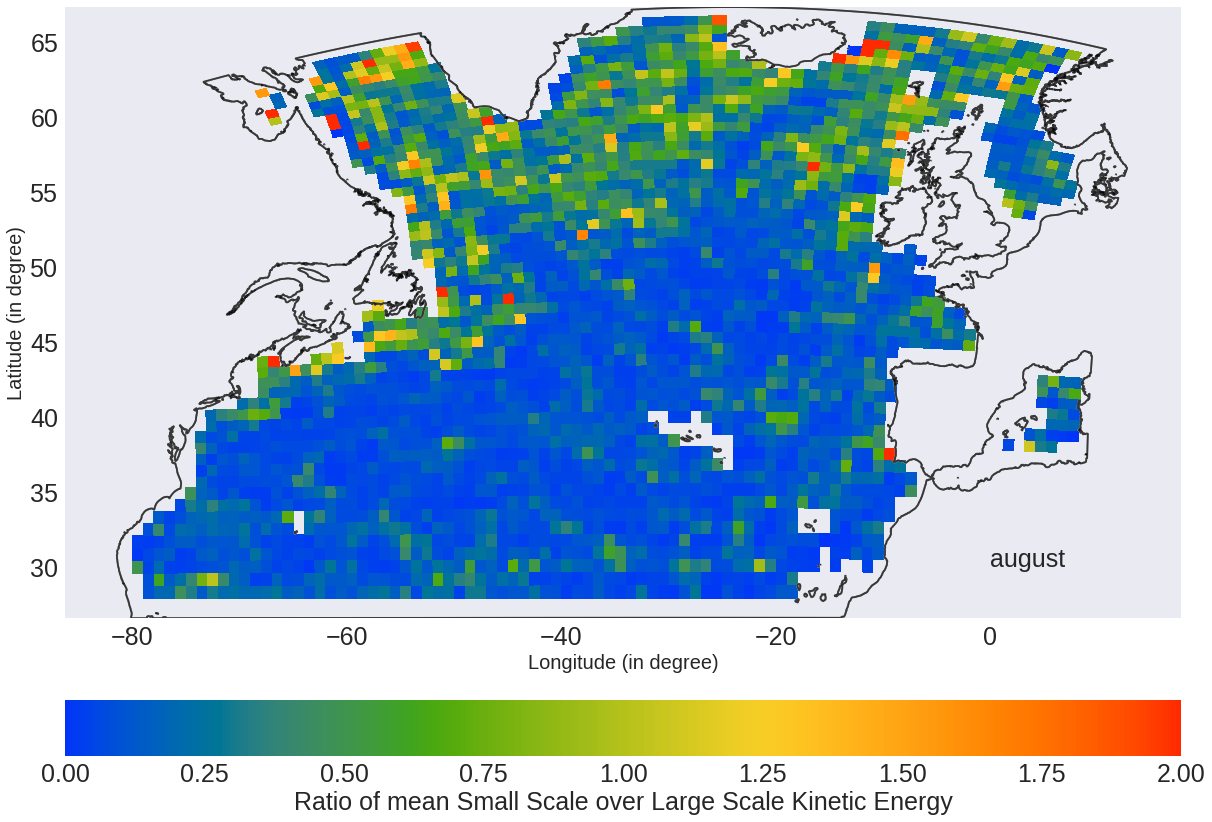

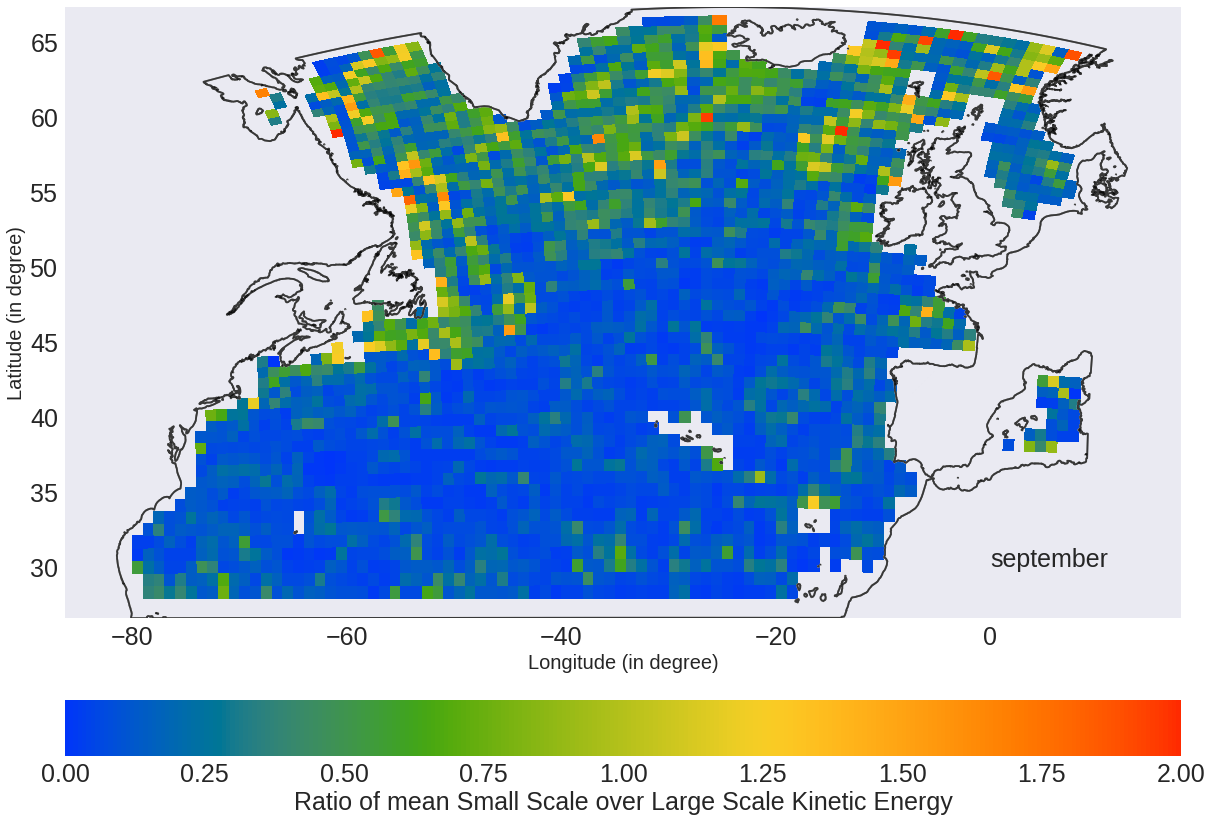

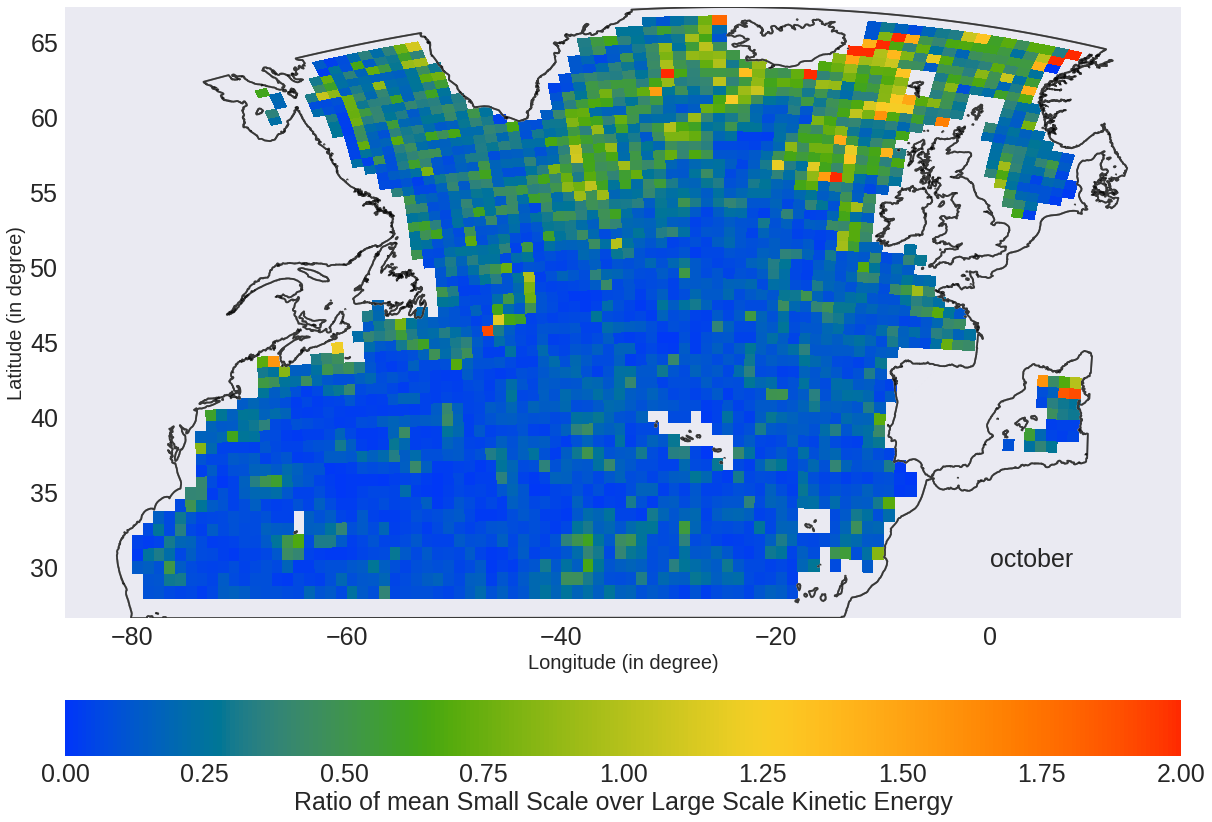

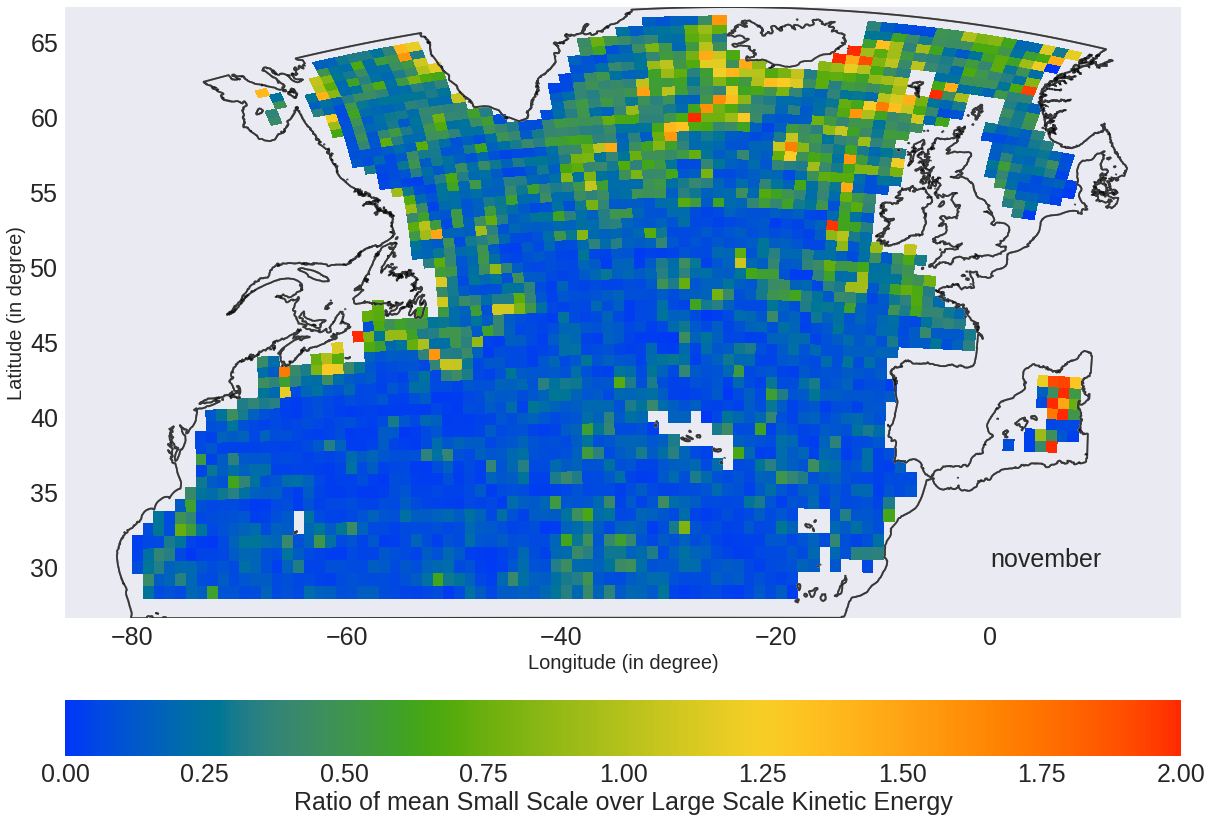

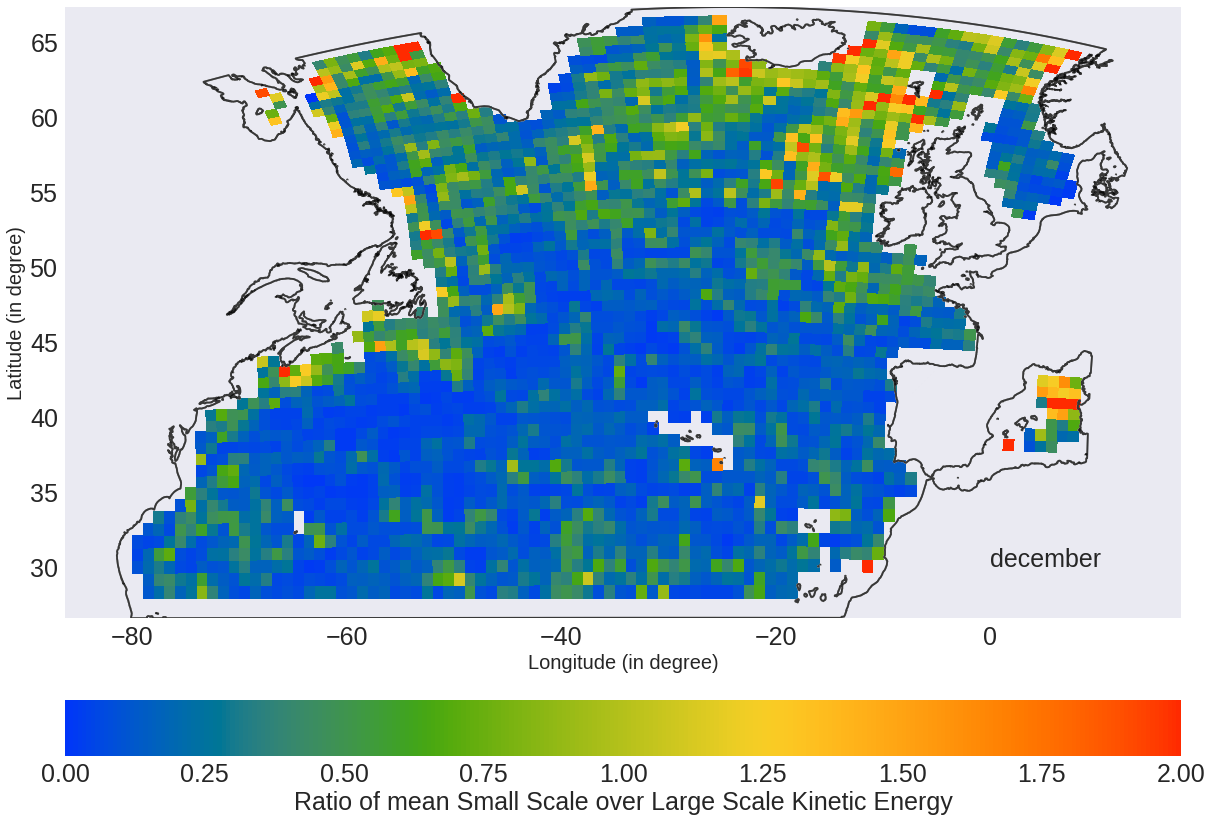

In [6]:
# the maps for the 12 months

for k in np.arange(12):
    plot_ratio_monthly(k,'KES','KEL')

In [7]:
# agregating the maps in an animated gif
!convert -delay 120 -loop 0 NATL60_ratio_KES_over_KEL_monthly_mean_coarse_m*.png NATL60_ratio_KES_over_KEL.gif

![Animated Monthly Maps of KES over KEL](NATL60_ratio_KES_over_KEL.gif "Animated Monthly Maps of KES over KEL")